# Analytical continuation of Green's Function in a two-band superconductor

This file tests the scripts written for simulation of a two-band $s^\pm$ superconductor. The SC order parameter $\Delta$ is solved self-consistently from BCS-Eliashberg theory both without and with impurity scattering, utilising summation over Matsubara frequencies. After obtaining the Green's functions at Matsubara frequencies (contrary to the usual convention, taken to be real instead of purely imaginary), the imaginary time technique is used to calculate the density of states by doing a Pade approximation and analytically continuation of the Green's function to the imaginary axis $(\omega_n \rightarrow z \rightarrow i \omega + \delta^+). $

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from gapeqn_library import *
from const import *
from scipy.integrate import quad, simpson
import time
import os
import random

Delta at T=0:  [ 0.65702129 -1.16405568]


In [2]:
# reading the path doesn't work with interactive Python
# curr_dir = os.path.dirname(os.path.realpath(__file__))
startT = time.time()
w_imag = -1j*omega_arr_fine-10**(-1.1) 

# helper functions
def beta(T):
    return 1/T
def SigmaCorrections(omega,Delta_h,Delta_e,Gamma):
    # self-consistently solves for the renormalised Matsubara frequency and gap size Deltatilde given their unnormalised counterparts and the impurity concentration; the unnoramlised omega and Delta also serve as initial guesses
    # Bang equations (11) and (12), definition of the renormalised Matsubara frequency and gap size
    omegatilde_cons = lambda omega,Tildes: omega + sigma_h_0(Tildes,Gamma) + sigma_e_0(Tildes,Gamma);
    Deltatilde_h_cons = lambda Delta_h,Tildes: Delta_h + sigma_h_1(Tildes,Gamma) + sigma_e_1(Tildes,Gamma);
    Deltatilde_e_cons = lambda Delta_e,Tildes: Delta_e + sigma_h_1(Tildes,Gamma) + sigma_e_1(Tildes,Gamma);

    #Self-consistent solution for omegatilde, Deltatilde_h, Deltatilde_e
    Eqn = lambda Tildes: np.array([Tildes[0]-omegatilde_cons(omega,Tildes),Tildes[1]-Deltatilde_h_cons(Delta_h,Tildes),Tildes[2]-Deltatilde_e_cons(Delta_e,Tildes)])

    TildesOut = fsolve(Eqn,[omega,Delta_h,Delta_e],xtol=1e-12);
    G = np.array([[G_h_0(TildesOut), G_h_1(TildesOut)],[ G_e_0(TildesOut), G_e_1(TildesOut)]])
    Sigma = np.array([[sigma_h_0(TildesOut,Gamma), sigma_h_1(TildesOut,Gamma)],[sigma_e_0(TildesOut,Gamma), sigma_e_1(TildesOut,Gamma)]]);

    return TildesOut.tolist()


def Sigma_Corrections_wrapper(Omega_Tilde,Delta_h,Delta_e,Gamma):
    # is this the density of states?
    TildesOut = np.array([SigmaCorrections(Omega_Tilde[n],Delta_h[n],Delta_e[n],Gamma) for n in range(len(Omega_Tilde))])
    G_h_imag = pade(w_imag,TildesOut[:,0],[G_h_0(t) for t in TildesOut])
    G_e_imag = pade(w_imag,TildesOut[:,0],[G_e_0(t) for t in TildesOut])
    return -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)


def G_and_Sigma_wrapper(Omega_Tilde,Delta_h,Delta_e,Gamma): #? G_and_Sigma takes in unnormalised omega, why use tilde here?
    G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(Omega_Tilde,Delta_h,Delta_e,Gamma)

    G_h_imag = pade(w_imag,Omega_Tilde,G_arr[:,0,0]) # why fitting to the renormalised frequencies?
    G_e_imag = pade(w_imag,Omega_Tilde,G_arr[:,1,0])

    return -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)



## I. A superconductor without impurity

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_16304\1116047802.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_16304\1116047802.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Delta.append(fsolve(lambda D: Eqn(D,t[-1]),Delta[-1],xtol=1e-13))


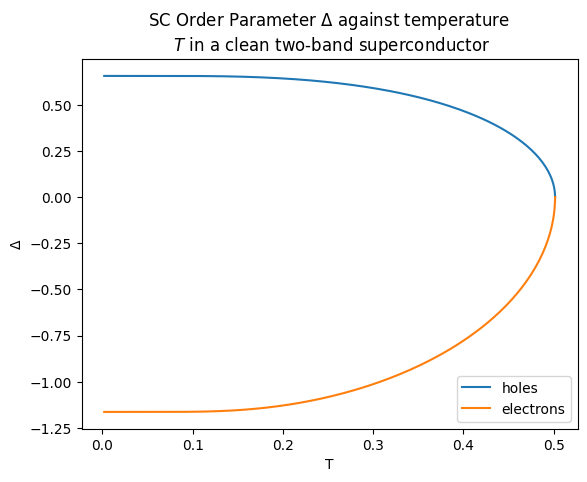

In [4]:
# trying
T = 0.6
out = Delta(T)
plt.plot(out[0], out[1][:,0], label = 'holes')
plt.plot(out[0], out[1][:,1], label = 'electrons')
plt.ylabel('$\Delta$')
plt.xlabel('T')
plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
plt.legend(loc = 'best')
plt.show()

## II. Evaluating $G(\omega_n)$ from Matsubara summation

In [4]:
# self-consistently solve for the tildes after guessing the untilded parameters
T_eval = 1e-2
Delta_h_init, Delta_e_init = initD # clean gap size
omega_eval = omegaMatsu(0, T_eval)
print('The tildes omega_n, Delta_h, Delta_e = ', f'{SigmaCorrections(omega_eval,Delta_h_init, Delta_e_init, 0.04)}', '\n', f'given untilted {omega_eval, Delta_h_init, Delta_e_init}')

The tildes omega_n, Delta_h, Delta_e =  [0.041654045009715195, 0.7460292907852083, -1.075047678386334] 
 given untilted (0.031415926535897934, np.float64(0.6570212873272268), np.float64(-1.1640556818443157))


In [5]:
# Use Matsubara Summation to calculate Chi(T, Gamma), SLOW! 
startT = time.time()
res = ChiMatsu(T_eval, Delta_h_init, Delta_e_init, 0.04)
endT = time.time()
print(f'A Single Matsubara summation over {max_it(T_eval)} points takes {(endT - startT):.5f} seconds')


A Single Matsubara summation over 10000 points takes 5.50696 seconds


In [6]:
# Find the order parameters from the gap equations.
ifSolveGap = True
if ifSolveGap:
    startT = time.time()
    res = SolveGap(initD,T_eval,0.04)
    endT = time.time()
    print(f'Solving the gap equations takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    np.savetxt('Tildes_total.txt',Tildes_total)
else:
    Tildes_total = np.loadtxt('Tildes_total.txt')
    Delta_out = np.array(unnormalised_Delta_from_tildes(Tildes_total[0],0.04))[1:]

Omega_Tilde = np.array([Tildes_total[i][0] for i in range(len(Tildes_total))])
Delta_h_Tilde = np.array([Tildes_total[i][1] for i in range(len(Tildes_total))])
Delta_e_Tilde = np.array([Tildes_total[i][2] for i in range(len(Tildes_total))])

Solving the gap equations takes 74.75594 seconds


In [7]:
# evaluate Green's function at Matsubara frequencies
omega = np.zeros(2*max_it(T_eval))
for n in np.arange(-max_it(T_eval),max_it(T_eval)):
    omega[n + max_it(T_eval)] = omegaMatsu(n,T_eval)
G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),0.04)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\S'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\S'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\S'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:7: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_xlabel('$\omega_n$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:15: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_xlabel('$\omega_n$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:30: SyntaxWarning: invalid escape s

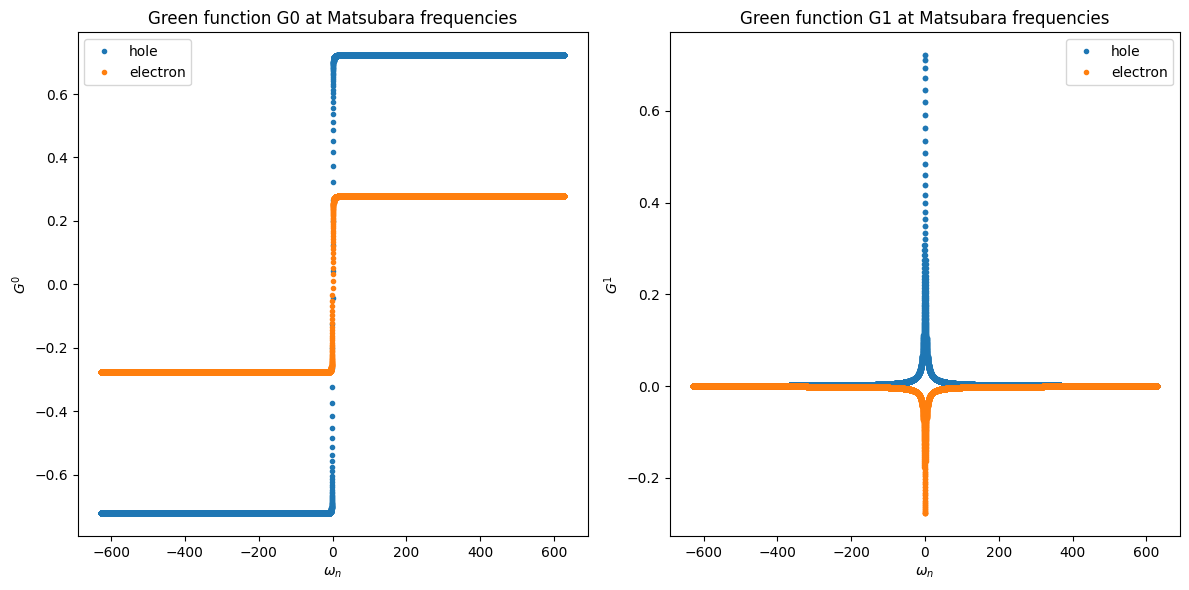

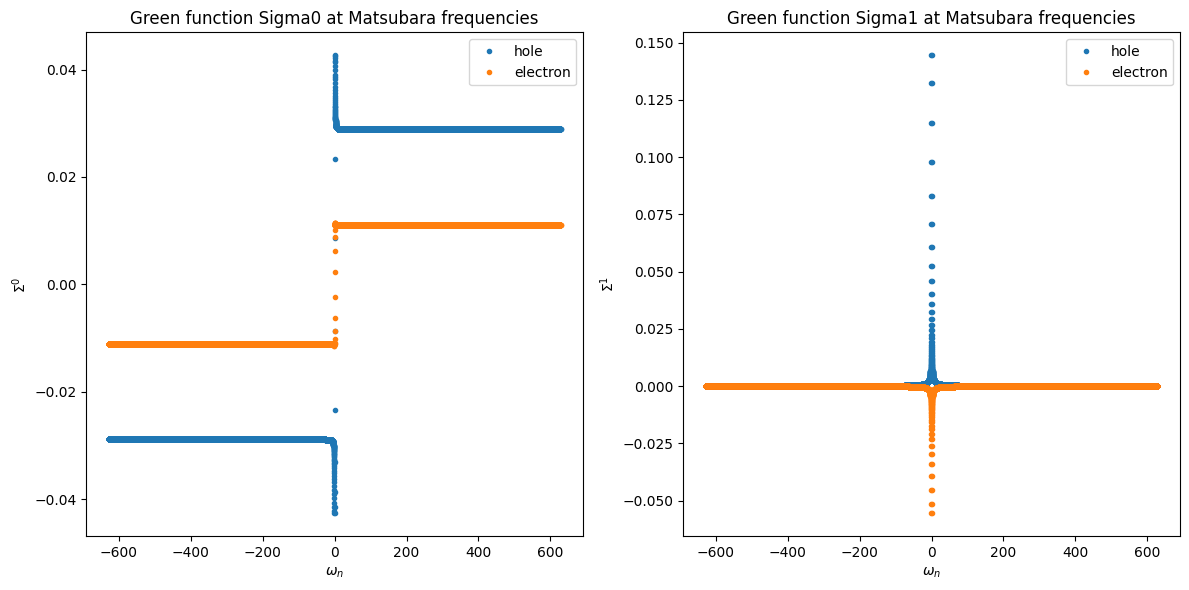

In [8]:
# plot the calculated Green's functions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].plot(omega, G_arr[:,0,0], '.', label='hole')
axs[0].plot(omega, G_arr[:,1,0], '.', label='electron')
axs[0].set_xlabel('$\omega_n$')
axs[0].set_ylabel('$G^0$')
axs[0].set_title('Green function G0 at Matsubara frequencies')
axs[0].legend(loc='best')

# Second plot
axs[1].plot(omega, G_arr[:,0,1], '.', label='hole')
axs[1].plot(omega, G_arr[:,1,1], '.', label='electron')
axs[1].set_xlabel('$\omega_n$')
axs[1].set_ylabel('$G^1$')
axs[1].set_title('Green function G1 at Matsubara frequencies')
axs[1].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

# plot the calculated self-energy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].plot(omega, Sigma_arr[:,0,0], '.', label='hole')
axs[0].plot(omega, Sigma_arr[:,1,0], '.', label='electron')
axs[0].set_xlabel('$\omega_n$')
axs[0].set_ylabel('$\Sigma^0$')
axs[0].set_title('Green function Sigma0 at Matsubara frequencies')
axs[0].legend(loc='best')

# Second plot
axs[1].plot(omega, Sigma_arr[:,0,1], '.', label='hole')
axs[1].plot(omega, Sigma_arr[:,1,1], '.', label='electron')
axs[1].set_xlabel('$\omega_n$')
axs[1].set_ylabel('$\Sigma^1$')
axs[1].set_title('Green function Sigma1 at Matsubara frequencies')
axs[1].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def ChiMatsu_test(temperature,Delta_h,Delta_e,Gamma):
    # test convergence in the Matsubara sum

    #This is actually analytically done, and it is the same as:
    ChiSubInt = lambda omega,Delta: 2*np.arctan(Omega_c/np.sqrt(omega**2+Delta**2))*Delta/np.sqrt(omega**2+Delta**2);



    ChiN_h =0; ChiN_e = 0;
    Chi_h = []; Chi_e=[]; Tildes_total = [];
    n=0;
    #The sum should go from -infty to infty

    for n in range(max_it(temperature)):
        omega = omegaMatsu(n,temperature);
        #Find renormalised omega and Delta_h, Delta_e
        Tildes = SigmaCorrections(omega,Delta_h,Delta_e,Gamma);
        Tildes_total.append(Tildes)

        # Bang equation (10)
        Chi_h.append(temperature*ChiSubInt(Tildes[0],Tildes[1]));
        ChiN_h = ChiN_h + Chi_h[-1];

        Chi_e.append(temperature*ChiSubInt(Tildes[0],Tildes[2]));
        ChiN_e = ChiN_e + Chi_e[-1];

        n = n+1;



    return Chi_h, Chi_e, ChiN_h, ChiN_e, Tildes_total

In [ ]:
# test convergence of the Matsubara sum explicitly
Chi_h, Chi_e, _, _, _= ChiMatsu_test(T_eval, Delta_out[0],Delta_out[1], 0.04)
Chi_h_partial_sum = np.array([np.sum(Chi_h[:i]) for i in range(len(Chi_h))])
Chi_e_partial_sum = np.array([np.sum(Chi_h[:i]) for i in range(len(Chi_h))])

In [ ]:
plt.plot(np.log(Chi_h),'.')
plt.xlabel('Iter Num')
plt.ylabel('log(an)')
plt.show()

plt.plot(Chi_h_partial_sum,'.')
plt.xlabel('Iter Num')
plt.ylabel('Sn')
plt.show()

## III. Solving the S.C. Gap Equation via FPade Decomposition

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:104: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Delta.append(fsolve(lambda D: Eqn(D,t[-1]),Delta[-1],xtol=1e-13))


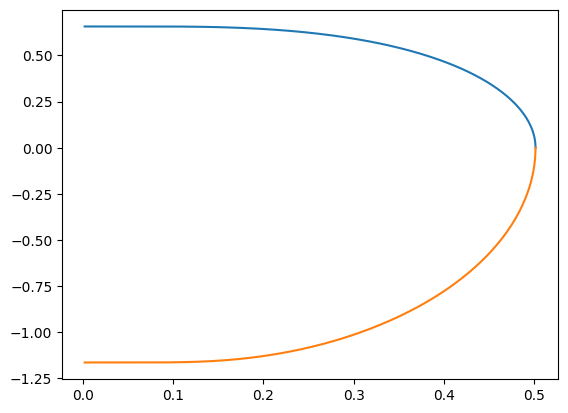

In [4]:
T = 0.6
out = Delta(T)
plt.plot(out[0], out[1][:,0], label = 'holes')
plt.plot(out[0], out[1][:,1], label = 'electrons')

In [5]:
def closest_values(arr1, arr2, val):
    # Compute the absolute difference for each value in val against all elements in arr1
    diff = np.abs(arr1[:, np.newaxis] - val)
    # Find the indices of the minimal differences for each value in val
    indices = diff.argmin(axis=0)
    # Use the indices to retrieve corresponding elements from arr2
    return arr2[indices]

In [107]:
# solve the gap from Tc down to Tmin
Tc_imp_arr = np.loadtxt('Tc.txt')
Tmin = 0.01
Gamma_arr = np.linspace(0,0.45,20)
Gamma_arr = np.array([0.12])
T_len = 80

initial_guess = []
res_smart_list = []

for i in range(len(Gamma_arr)): # smart guess
    Gamma = Gamma_arr[i]
    Tc = closest_values(Tc_imp_arr[0], Tc_imp_arr[1],Gamma)[0]
    T_arr = np.linspace(Tc, Tmin, T_len)
    for j in range(len(T_arr)):
        T_eval = T_arr[j]
        
        if j == 0: # at Tc
            gapGuess = initD
        elif np.abs(initial_guess[-1][2][0]) < 0.1: # use the last value as an initial guess
            gapGuess = initD
        else:
            gapGuess = initial_guess[-1][2]
        
        sol = SolveGap_FPade(gapGuess,T_eval,Gamma)[0]

        initial_guess.append([Gamma, T_eval, sol])

for i in range(len(Gamma_arr)): # purely using initD
    Gamma = Gamma_arr[i]
    Tc = closest_values(Tc_imp_arr[0], Tc_imp_arr[1],Gamma)[0]
    T_arr = np.linspace(Tc, Tmin, T_len)
    for j in range(len(T_arr)):
        T_eval = T_arr[j]
        
        sol_smart = SolveGap_FPade(initD, T_eval, Gamma)[0]

        res_smart_list.append([Gamma, T_eval, sol])


c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:278: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);


Time used for smart guess loop: 17.3763 seconds
Time used for initD loop: 24.2162 seconds


In [52]:
# solve the gap equations at different temperatures 
T_eval_indices = [0,70,122,243,295,408]
Gamma = 0.0
N_arr = np.append(np.arange(5,100,2),np.arange(100,200,10))
gap_arr = np.zeros((len(T_eval_indices),len(N_arr)))
err_arr = np.zeros((len(T_eval_indices),len(N_arr)))
for i in range(len(T_eval_indices)):
    true_val = out[1][T_eval_indices[i],0]
    for j in range(len(N_arr)):
        T_eval = out[0][T_eval_indices[i]]
        N_pade = N_arr[j]
        gap_arr[i,j] = SolveGap_FPade(out[1][T_eval_indices[i]],T_eval,Gamma,N_FPade=N_pade)[0][0]
        err_arr[i,j] = np.abs(gap_arr[i,j] - true_val) / true_val

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:229: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);


C:\Users\tcsxx\AppData\Local\Temp\ipykernel_4380\342301553.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(N_arr,np.log10(err_arr[i,:]),'+',label = f'T = {out[0][T_eval_indices[i]]:.4f}K')


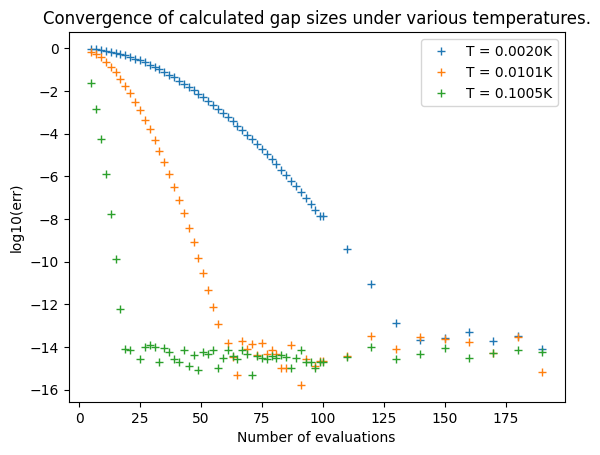

In [53]:
for i in [0,2,4]:
    plt.plot(N_arr,np.log10(err_arr[i,:]),'+',label = f'T = {out[0][T_eval_indices[i]]:.4f}K')
plt.xlabel('Number of evaluations')
plt.ylabel('log10(err)')
plt.legend(loc = 'best')
plt.title('Convergence of calculated gap sizes under various temperatures.')
plt.show()

In [5]:
# decrapted: no longer able to expplicitely provide where to truncate the summation
# solve the gap equations at different 
T_eval_index_arr = [0,50,122,295]
Gamma_arr = [0,0.04,0.16,0.40]
N_arr = np.append(np.arange(5,150,10),np.arange(150,400,20))
gap_arr = np.zeros((len(T_eval_index_arr),len(Gamma_arr),len(N_arr)))
err_arr = np.zeros((len(T_eval_index_arr),len(Gamma_arr),len(N_arr)))
for k in range(len(T_eval_index_arr)):
    T_eval = out[0][T_eval_index_arr[k]]
    Delta_estimates = out[1][T_eval_index_arr[k]]
    for i in range(len(Gamma_arr)):
        Gamma = Gamma_arr[i]
        true_val = SolveGap_FPade(Delta_estimates,T_eval,Gamma,N_FPade=500)[0][0]
        for j in range(len(N_arr)):
            N_pade = N_arr[j]
            gap_arr[k,i,j] = SolveGap_FPade(Delta_estimates,T_eval,Gamma,N_FPade=N_pade)[0][0]
            err_arr[k,i,j] = np.abs(gap_arr[k,i,j] - true_val) / true_val

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:278: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  TildesOut = fsolve(Eqn,[omega,Delta_h,Delta_e],xtol=1e-12);
c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:278: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  TildesOut = fsolve(Eqn,[omega,Delta_h,Delta_e],xtol=1e-12);


Convergence to 1e-6 is not guaranteed


c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:240: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);


Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence 

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:240: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);


Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence to 1e-6 is not guaranteed
Convergence 

C:\Users\tcsxx\AppData\Local\Temp\ipykernel_13776\1093654503.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(N_arr,np.log10(err_arr[i,Gamma_index,:]),'+',label = f'T = {out[0][T_eval_index_arr[i]]:.4f}K')


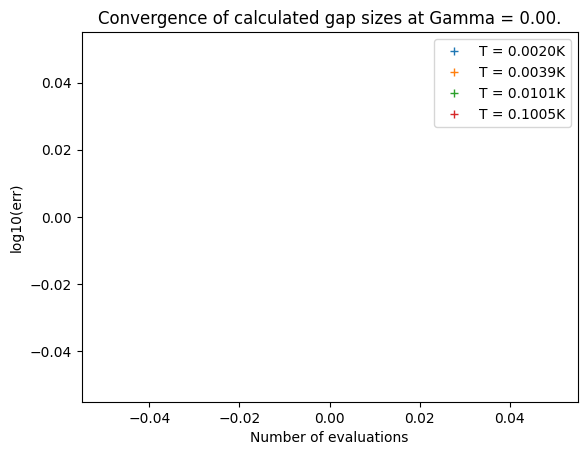

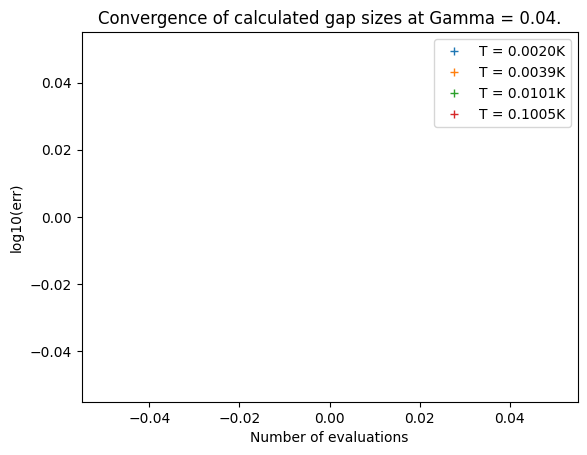

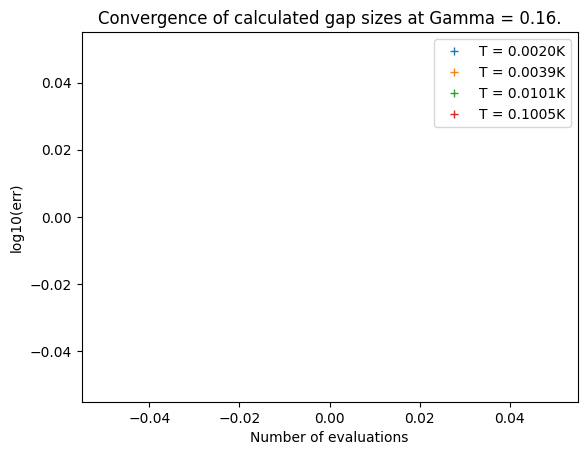

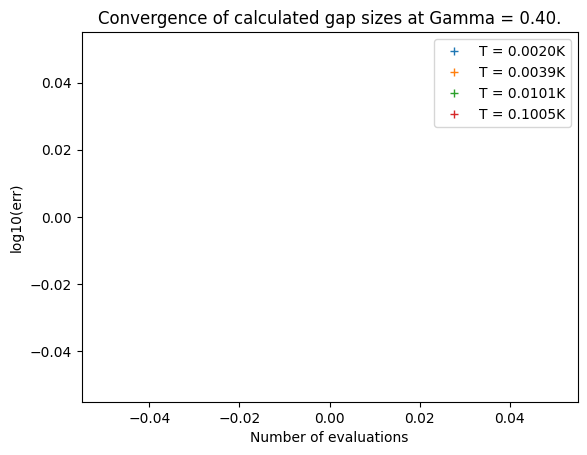

In [6]:
T_eval_index_arr = [0,50,122,295]
Gamma_arr = [0,0.04,0.16,0.40]
N_arr = np.append(np.arange(5,150,10),np.arange(150,400,20))
for Gamma_index in [0,1,2,3]:
    Gamma = Gamma_arr[Gamma_index]
    for i in [0,1,2,3]:
        plt.plot(N_arr,np.log10(err_arr[i,Gamma_index,:]),'+',label = f'T = {out[0][T_eval_index_arr[i]]:.4f}K')
    plt.xlabel('Number of evaluations')
    plt.ylabel('log10(err)')
    plt.legend(loc = 'best')
    plt.title(f'Convergence of calculated gap sizes at Gamma = {Gamma:.2f}.')
    plt.show()

In [7]:
Gamma_arr = [0.04,0.16]
T_eval_arr = np.append(np.linspace(0.01,0.1,20),np.linspace(0.15,0.4,8))
Delta_h_autoTruncate_arr = np.zeros((len(Gamma_arr),len(T_eval_arr)))
Delta_h_safe_arr = np.zeros((len(Gamma_arr),len(T_eval_arr)))
for i in range(len(Gamma_arr)):
    Gamma = Gamma_arr[i]
    for j in range(len(T_eval_arr)):
        T_eval = T_eval_arr[j]
        Tc = 0.5016084
        Delta_guess = out[1][0,:] * np.tanh(1.74 * np.sqrt(Tc / T_eval - 1))
        Delta_h_autoTruncate_arr[i,j] = SolveGap_FPade(Delta_guess,T_eval,Gamma)[0][0]
        Delta_h_safe_arr[i,j] = SolveGap_FPade(Delta_guess,T_eval,Gamma,smartTruncate=False)[0][0]
err_arr = np.abs(Delta_h_autoTruncate_arr - Delta_h_safe_arr ) / Delta_h_safe_arr

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:240: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_13776\3280956915.py:13: RuntimeWarning: divide by zero encountered in divide
  err_arr = np.abs(Delta_h_autoTruncate_arr - Delta_h_safe_arr ) / Delta_h_safe_arr


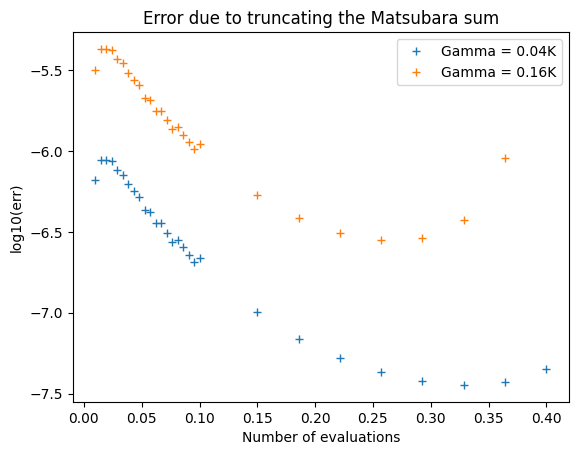

In [10]:
Gamma_arr = [0.04,0.16]
T_eval_arr = np.append(np.linspace(0.01,0.1,20),np.linspace(0.15,0.4,8))
for i in [0,1]:
    plt.plot(T_eval_arr,np.log10(err_arr[i,:]),'+',label = f'Gamma = {Gamma_arr[i]:.2f}K')
plt.xlabel('Number of evaluations')
plt.ylabel('log10(err)')
plt.legend(loc = 'best')
plt.title('Error due to truncating the Matsubara sum')
plt.show()

## IV. Solve for the Green's function on the real axis


In [144]:
T_eval = 0.1
Tc = 0.50
Gamma = 0.04
Delta_guess = out[1][0,:] * np.tanh(1.74 * np.sqrt(Tc / T_eval - 1))
Delta_h, Delta_e = SolveGap_FPade(Delta_guess,T_eval,Gamma)[0]

delta_list = [10**0, 10**(-0.5),10**(-1), 10**(-1.5), 10**(-2)]
res_list = []
for delta in delta_list:
    z = np.linspace(-3,3,100) * 1j + delta
    res = G_and_Sigma(z,Delta_h, Delta_e,Gamma)
    res_list.append(res[0])

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_45208\2707553392.py:15: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(np.imag(z_imag), np.real(G_imag) - 1.5 * i, '-', label=f'$\delta = 1E$ {np.log10(delta):.1f}', color=color)


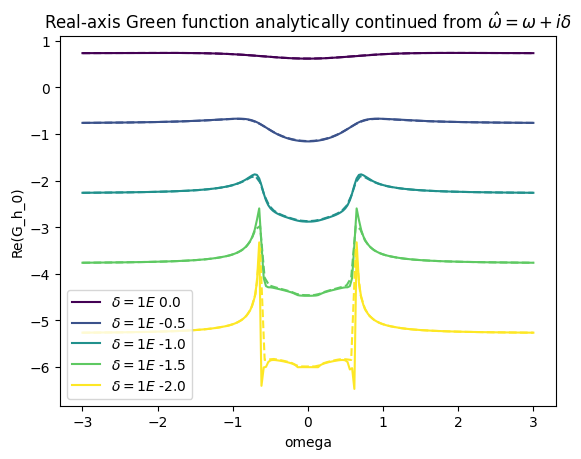

In [186]:
# Define colors using a colormap or a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(delta_list)))  # Using a colormap

z_imag = np.linspace(-3, 3, 200) * 1j
for i in range(len(delta_list)):
    delta = delta_list[i]
    res = res_list[i]
    G_arr_h = res[:, 0, 0]

    G_imag = pade(z_imag, z, G_arr_h)
    
    # Use the loop index `i` to select a color
    color = colors[i]
    
    plt.plot(np.imag(z_imag), np.real(G_imag) - 1.5 * i, '-', label=f'$\delta = 1E$ {np.log10(delta):.1f}', color=color)
    plt.plot(np.imag(z), np.real(G_arr_h) - 1.5 * i, '--', color=color)

plt.xlabel('omega')
plt.ylabel('Re(G_h_0)')
plt.legend(loc='best')
plt.title(r'Real-axis Green function analytically continued from $\hat{\omega} = \omega + i \delta$')
plt.show()

## V. Thermodynamic Calculation from Matsubara Summation

From path integral formalism, the free energy
$$ F = k_B T \sum_{\omega_n} \ln{\mathrm{det}(\mathcal{G}_\omega^{-1})} + F_0$$
where 

$$ 
\mathcal{G}_\omega = ( \mathcal{G}_h^0 (\mathbf{k}, i \omega_n) \qquad \mathcal{G}_h^1 (\mathbf{k}, i \omega_n) \\  \mathcal{G}_{e}^{1 \dagger} (\mathbf{k}, i \omega_n) \qquad \mathcal{G}_e^0 (\mathbf{k}, i \omega_n) )
$$

In [3]:
# calculate the free energy perturbatively
def log_cosh(x):
    return np.where(x < 30, np.log(np.cosh(x)), x - np.log(2))
def first_order_correction(omega, Delta, epsilon, delta_omega, delta_Delta):
    # omega, delta_omega, delta_Delta are 1D array of length N
    # Delta and epsilon are scalar
    # omega, Delta, epsilon are unnormalised parameters
    # delta_omega and delta_Delta are the correction from impurity scattering 
    numerator = 2 * (Delta * delta_omega + omega * delta_Delta)
    denominator = Delta**2 + omega**2 + epsilon**2
    return numerator / denominator 

def second_order_correction(omega,Delta, epsilon, delta_omega, delta_Delta):
    # return second order perturbation in perturbation of tilded ln(omega**2 + Delta**2 + eps**2), before summing over all n
    denominator = (Delta**2 + omega**2 + epsilon**2)**2 
    numerator1 = (Delta**2 + epsilon**2 - omega**2) * delta_omega**2 
    numerator2 = (-Delta**2 + epsilon**2 + omega**2) * delta_Delta**2 
    numerator3 = -(4 * Delta * omega) * delta_omega * delta_Delta
    return (numerator1 + numerator2 + numerator3) / denominator 

def third_order_correction(omega,Delta, epsilon, delta_omega, delta_Delta):
    # return third order perturbation in perturbation of tilded ln(omega**2 + Delta**2 + eps**2), before summing over all n
    denominator = (Delta**2 + omega**2 + epsilon**2)**3 
    numerator1 = 2 * omega/3 * (-3 * Delta**2 - 3 * epsilon**2 + 1 * omega**2) * delta_omega**3 
    numerator2 = 2 * Delta * (-1 * Delta**2 - 1 * epsilon**2 + 3 * omega**2) * delta_omega**2 * delta_Delta 
    numerator3 = 2 * omega * (3 * Delta**2 - 1 * epsilon**2 - 1 * omega**2) * delta_omega * delta_Delta**2
    numerator4 = 2 * Delta/3 * (1 * Delta**2 - 3 * epsilon**2 - 3 * omega**2) * delta_Delta**3
    return (numerator1 + numerator2 + numerator3 + numerator4) / denominator

def tilded_log(epsilon, T,omega, Delta, delta_omega, delta_Delta):
    # epsilon and Delta are scalars, all the others are 1*N arrays
    # return tilded ln(omega**2 + Delta**2 + epsilon**2) summed over Matsubara frequencies, with regularised unperturbed part as a scalar
    Ek = np.sqrt(Delta**2 + epsilon**2)
    untilded = 2 * (np.log(2) + log_cosh(beta(T) * Ek / 2))
    res = untilded + np.sum(second_order_correction(omega,Delta,epsilon,delta_omega,delta_Delta)) + np.sum(third_order_correction(omega,Delta,epsilon,delta_omega,delta_Delta))
    return res

def free_energy_perturbation(T,Gamma,Tildes_total):
    # update needed, change it such that tilded Gaps are used for the scalar as well
    # return the free energy at a given temperature T and impurity level Gamma with pre-calculated solution to the self-consistent equations
    _, Delta_h, Delta_e = unnormalised_Delta_from_tildes(Tildes_total[0], Gamma)
    # calculate the original Matsubara frequencies at this temperature
    maxN = int(np.size(Tildes_total[:,0])/2)
    omega_arr = omegaMatsu(np.arange(-maxN, maxN),T)

    # calculate the tilde correction
    delta_omega = Tildes_total[:,0] - omega_arr
    delta_Delta_h = Tildes_total[:,1] - Delta_h 
    delta_Delta_e = Tildes_total[:,2] - Delta_e 

    # calculate intraband conribution to the free energy 
    log_h = -1 * T * Nh * quad(tilded_log,0,Omega_c,args = (T, omega_arr, Delta_h, delta_omega, delta_Delta_h))[0]
    log_e = -1 * T * Ne * quad(tilded_log,0,Omega_c,args = (T, omega_arr, Delta_e, delta_omega, delta_Delta_e))[0]
    
    # intraband contribution to the free energy
    detV = Vee * Vhh - Vhe**2 
    F_OP = 1/detV * (Vhh * np.abs(Delta_e)**2 + Vee * np.abs(Delta_h)**2 - 2 * Vhe * np.real(np.conjugate(Delta_e) * Delta_h)) 

    return (log_h + log_e - F_OP)

In [4]:
def tilded_log_FPade(epsilon, T,omega_poles, Delta, delta_omega, delta_Delta,weights):
    # calculate the log term in the free energy expansion. The summation is done using Pade decomposition, Renormalised omega, delta, and weights need to be supplied, as well as Pade weights. 
    Ek = np.sqrt(Delta**2 + epsilon**2)
    untilded = 2 * (np.log(2) + log_cosh(beta(T) * Ek / 2))
    res = untilded + np.sum(weights * second_order_correction(omega_poles,Delta,epsilon,delta_omega,delta_Delta)) + np.sum(weights * third_order_correction(omega_poles,Delta,epsilon,delta_omega,delta_Delta))
    return res

def free_energy_perturbation_FPade(T, Delta_h, Delta_e, Tildes_total_FPade):
    # Tildes_total_FPade is generated via Pade decomposiiton scheme
    # find Pade poles
    N_FPade = np.shape(Tildes_total_FPade)[0]

    try: # if running in IPython environment
        FPade_dict = np.load('FPade_Poles_and_Weights.npy',allow_pickle=True).item()
    except:
        try: # if running in Python environment
            FPade_dict = np.load(curr_dir+'/FPade_Poles_and_Weights.npy',allow_pickle=True).item()
        except: # if the lookup table for weights and poles hasn't been generated before. This only works in IPython environments.
            print('Could not find pole and weights for Pade decomposition. Generating weights and poles...')
            FPade_maxN_list = np.array([5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,150,200,500,1000])
            FPade_dict = generate_FPade_poles_and_weights(FPade_maxN_list)
            print('Weights and Poles generated and saved.')
    positive_poles, weights, = find_best_Pade_params(N_FPade, FPade_dict)

    omega_arr = positive_poles*T

    # calculate the tilde corrections
    delta_omega = Tildes_total_FPade[:,0] - omega_arr
    delta_Delta_h = Tildes_total_FPade[:,1] - Delta_h 
    delta_Delta_e = Tildes_total_FPade[:,2] - Delta_e
    
    # calculate intraband conribution to the free energy 
    log_h = -1 * T * Nh * quad(tilded_log_FPade,0,Omega_c,args = (T, omega_arr, Delta_h, delta_omega, delta_Delta_h, weights))[0]
    log_e = -1 * T * Ne * quad(tilded_log_FPade,0,Omega_c,args = (T, omega_arr, Delta_e, delta_omega, delta_Delta_e, weights))[0]
    
    # intraband contribution to the free energy
    detV = Vee * Vhh - Vhe**2 
    F_OP = 1/detV * (Vhh * np.abs(Delta_e)**2 + Vee * np.abs(Delta_h)**2 - 2 * Vhe * np.real(np.conjugate(Delta_e) * Delta_h)) 

    return (log_h + log_e - F_OP)

In [5]:
def load_gap_results(file_path):
    # return saved FPade gap solutions in arrays, and a list of masks corresponding to different gamma values for easier postprocessing
    df = pd.read_csv(file_path, sep='\t',names = ['Gamma', 'T/Tc', 'Delta_h', 'Delta_e', 'TildesTotal'], header = 1)
    # Extract the columns into numpy arrays
    gamma_values = df['Gamma'].values
    t_over_tc_values = df['T/Tc'].values
    delta_h_values = df['Delta_h'].values
    delta_e_values = df['Delta_e'].values
    
    # Create a list of masks for each unique gamma value
    unique_gamma_values = np.unique(gamma_values)
    mask_list = [gamma_values == gamma for gamma in unique_gamma_values]
    # Convert the 'TildesTotal' column strings to 2D numpy arrays
    # Use eval() to convert string representation to actual numpy arrays
    tildes_total_list = [np.array(eval(tildes)) for tildes in df['TildesTotal']]

    return gamma_values, t_over_tc_values, delta_h_values, delta_e_values, tildes_total_list, mask_list

def numerical_derivative(y,x):
    """
    Compute the derivative of y with respect to x using finite difference method.
    
    Parameters:
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    
    Returns:
    - dy_dx: array-like, shape (n,), the derivative dy/dx
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy_dx = np.zeros_like(y)

    # Central difference for interior points
    dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])

    # Forward/backward difference for boundary points
    dy_dx[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy_dx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dy_dx
def heat_capacity_F(F_arr, T_arr):
    # calculate the heat capacity given free energy array and temperature array
    C = - T_arr *  numerical_derivative(numerical_derivative(F_arr , T_arr), T_arr)
    return C 
def entropy_F(F_arr, T_arr):
    S = - numerical_derivative(F_arr, T_arr)
    return S

In [6]:
def free_energy_wrapper(T,Gamma,subfolder_name = ''):
    # needs updating! free_energy takes in different arguments
    # self-consistently solve for Nambu-Gor'kov Green's function at a given temperature and impurity level, then calculate the free energy and save the data 
    T_eval = T
    # solve the gap equation
    startT = time.time()
    res = SolveGap(initD,T_eval,Gamma)
    endT = time.time()
    print(f'Solving the gap equations at T = {T} and Gamma = {Gamma} takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    Tildes_total = np.array(Tildes_total)
    if len(subfolder_name) > 0: # save the data
        directory = subfolder_name + '/'
    else:
        directory = subfolder_name
    saveName = directory + f'T{T:.5f}_Gamma{Gamma:.3f}_Tildes_total.npy'  
    np.save(saveName,Tildes_total)

    # evaluate Green's function at Matsubara frequencies
    omega = np.zeros(2*max_it(T))
    for n in np.arange(-max_it(T),max_it(T)):
        omega[n + max_it(T)] = omegaMatsu(n,T_eval)
    G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),Gamma) 

    saveName = directory + f'T{T:.5f}_Gamma{Gamma:.3f}_G_arr.npy'  
    np.save(saveName,G_arr) 

    return free_energy_perturbation(T_eval,Gamma,Tildes_total)

def unnormalised_Delta_from_tildes(tildes, Gamma):
    # return Delta_e and Delta_h from a N*3 array of [omega_tilde, Deltatilde_h, Deltatilde_e] under impurity level Gamma
    omega_tilde, Deltatilde_h, Deltatilde_e = tildes
    Delta_h = Deltatilde_h - sigma_h_1(tildes, Gamma) - sigma_e_1(tildes, Gamma)
    Delta_e = Deltatilde_e - sigma_h_1(tildes, Gamma) - sigma_e_1(tildes, Gamma) 
    omega_n = omega_tilde - sigma_h_0(tildes, Gamma) - sigma_h_0(tildes, Gamma)
    return omega_n, Delta_h, Delta_e 

def numerical_derivative(y,x):
    """
    Compute the derivative of y with respect to x using finite difference method.
    
    Parameters:
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    
    Returns:
    - dy_dx: array-like, shape (n,), the derivative dy/dx
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy_dx = np.zeros_like(y)

    # Central difference for interior points
    dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])

    # Forward/backward difference for boundary points
    dy_dx[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy_dx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dy_dx
def heat_capacity_F(F_arr, T_arr):
    # calculate the heat capacity given free energy array and temperature array
    C = - T_arr *  numerical_derivative(numerical_derivative(F_arr , T_arr), T_arr)
    return C 
def entropy_F(F_arr, T_arr):
    S = - numerical_derivative(F_arr, T_arr)
    return S

def load_results(T, Gamma, directory, mustContain=''):
    """
    Load specific .npy files from a directory based on provided temperature (T) and gamma (Gamma) values.

    This function searches a specified directory for .npy files that follow a naming convention containing 
    'T{T_value}_G{Gamma_value}_G_arr.npy' or 'T{T_value}_G{Gamma_value}_Tildes_total.npy'. It identifies the files 
    whose names contain T_value closest to the provided T and Gamma_value closest to the provided Gamma. An optional 
    argument allows users to filter files that must include a specific string in their names. The function assumes 
    there are exactly two matching files in the directory: one containing 'G_arr' and one containing 'Tildes_total'. 
    It loads and returns the stored arrays from these files.

    Parameters:
    -----------
    T : float
        The target temperature value to match in the filenames.

    Gamma : float
        The target gamma value to match in the filenames.

    directory : str
        The directory path where the .npy files are located.

    mustContain : str, optional
        A string that the filenames must contain to be considered (default is '').

    Returns:
    --------
    G_arr : numpy.ndarray
        The array loaded from the file containing 'G_arr' in its name.

    Tildes_total : numpy.ndarray
        The array loaded from the file containing 'Tildes_total' in its name.

    Raises:
    -------
    FileNotFoundError
        If the function cannot find exactly two matching files for the specified T and Gamma values.

    Examples:
    ---------
    >>> directory_path = '/path/to/your/directory'
    >>> T = 0.052
    >>> Gamma = 0.0
    >>> mustContain = ''  # Optional string filtering
    >>> G_arr, Tildes_total = load_results(T, Gamma, directory_path, mustContain)
    >>> print("Loaded G_arr shape:", G_arr.shape)
    >>> print("Loaded Tildes_total shape:", Tildes_total.shape)
    """
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter files by those containing mustContain string
    if mustContain:
        files = [f for f in files if mustContain in f]
    
    # Initialize variables to store closest matches
    closest_G_arr_file = None
    closest_Tildes_total_file = None
    min_combined_diff_G_arr = float('inf')
    min_combined_diff_Tildes_total = float('inf')
    
    # Iterate over files to find closest T and Gamma matches
    for filename in files:
        if filename.endswith('.npy'):
            if 'G_arr' in filename or 'Tildes_total' in filename:
                # Extract T_value and Gamma_value from the filename
                parts = filename.split('_')
                T_value = None
                Gamma_value = None
                for part in parts:
                    if part.startswith('T0'):
                        T_value = float(part[1:])
                    elif part.startswith('Gamma'):
                        Gamma_value = float(part[5:])
                
                # Skip files that do not have valid T or Gamma values
                if T_value is None or Gamma_value is None:
                    continue
                
                # Calculate combined difference with requested T and Gamma
                combined_diff = abs(T_value - T) + abs(Gamma_value - Gamma)
                
                # Update closest files based on the combined difference
                if 'G_arr' in filename and combined_diff < min_combined_diff_G_arr:
                    closest_G_arr_file = filename
                    min_combined_diff_G_arr = combined_diff
                if 'Tildes_total' in filename and combined_diff < min_combined_diff_Tildes_total:
                    closest_Tildes_total_file = filename
                    min_combined_diff_Tildes_total = combined_diff
    
    # Check if both closest files are found
    if closest_G_arr_file is None or closest_Tildes_total_file is None:
        raise FileNotFoundError(f"Could not find matching files for T={T} and Gamma={Gamma} in directory '{directory}'")
    
    # Load the arrays from the found files
    G_arr = np.load(os.path.join(directory, closest_G_arr_file))
    Tildes_total = np.load(os.path.join(directory, closest_Tildes_total_file))
    
    # print(closest_G_arr_file)
    return G_arr, Tildes_total

def partialSum(arr):
    # returns partial sum of a sequence
    summed = np.zeros(np.size(arr))
    for i in np.arange(len(arr)):
        summed[i] = np.sum(arr[:i+1])
    return summed

### Perturbative Expansion 
Here, we deal with the diverging sum
$$\sum_{i \omega_n} \ln(\tilde{\omega}_n^2 + \tilde{\Delta}_n^2 + \varepsilon^2) 
= \sum_{i \omega_n} \ln(\omega_n^2 + \Delta_n^2 + \varepsilon^2) + \sum_{\omega_n}\frac{2 (\Delta (\delta \omega_n) + \omega_n (\delta \Delta))}{\Delta^2 + \omega_n^2 + \varepsilon^2} + \mathcal{O}(\delta^2)$$
where the first term can be renormalised to be 
$$ \sum_{i \omega_n} \ln(\omega_n^2 + \Delta_n^2 + \varepsilon^2) = 2 \ln(2 \cosh(\beta \sqrt{\Delta^2 + \varepsilon^2}/2))$$
and the the perturbation series is convergent.

Note however, since $\delta \omega_n$ is odd and $\delta \Delta$ is even, the first-order correction is zero. Hence, we go to the second order, which is 
$$\sum_{\omega_n} \frac{1}{(\omega_n^2 + \varepsilon^2 + \Delta^2)^2} \left[ (\Delta^2 + \varepsilon^2 - \omega_n^2) \delta \omega_n^2 + (-\Delta^2 + \varepsilon^2 + \omega_n^2) \delta \Delta^2 - (4 \Delta \omega_n) \delta \omega_n \delta \Delta\right]$$ 
which goes to zero as $\mathcal{O}(\omega_n^{-4}).$ In the small $\omega_n$ limit, the correction goes as $\delta^2.$

Just to be safe, we can also include the third-order perturbation (see notebook for this)

In [ ]:
# calculate free energy at different temperature and impurity level. Takes ~3 hours
"""
Gamma_arr = np.array([0.04])
T_arr = np.linspace(0.02, 0.15, 15)
F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        F_arr[i,j] = free_energy_wrapper(T_eval,Gamma, subfolder_name='data_0820_variable_maxit')
"""

Solving the gap equations at T = 0.02 and Gamma = 0.04 takes 362.60883 seconds
Solving the gap equations at T = 0.029285714285714286 and Gamma = 0.04 takes 242.99998 seconds
Solving the gap equations at T = 0.038571428571428576 and Gamma = 0.04 takes 187.21826 seconds
Solving the gap equations at T = 0.04785714285714286 and Gamma = 0.04 takes 174.82118 seconds
Solving the gap equations at T = 0.05714285714285715 and Gamma = 0.04 takes 150.20901 seconds
Solving the gap equations at T = 0.06642857142857143 and Gamma = 0.04 takes 112.79369 seconds
Solving the gap equations at T = 0.07571428571428572 and Gamma = 0.04 takes 95.76740 seconds
Solving the gap equations at T = 0.085 and Gamma = 0.04 takes 84.82120 seconds
Solving the gap equations at T = 0.09428571428571429 and Gamma = 0.04 takes 76.71658 seconds
Solving the gap equations at T = 0.10357142857142858 and Gamma = 0.04 takes 72.41589 seconds
Solving the gap equations at T = 0.11285714285714286 and Gamma = 0.04 takes 72.01356 second

In [7]:
# Define the directory where your .npy files are stored
directory = 'data_0820_variable_maxit'

# calculate free energy at different temperature and impurity level
Gamma_arr = np.array([0,0.04,0.16])
T_arr = np.linspace(0.02, 0.15, 15)

F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
C_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_h_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_e_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        G_arr, Tildes_total = load_results(T_eval, Gamma, directory)
        _, Delta_h, Delta_e = unnormalised_Delta_from_tildes(Tildes_total[0], Gamma)
        Delta_h_arr[i,j] = Delta_h
        Delta_e_arr[i,j] = Delta_e
        F_arr[i,j] = free_energy_perturbation(T_eval,Gamma,Tildes_total)
        # F_arr[i,j] = free_energy(G_arr,Delta_h,Delta_e, T_eval)
for i in range(np.size(Gamma_arr)):
    Gamma = Gamma_arr[i]
    C_arr[i,:] = heat_capacity_F(F_arr[i,:], T_arr)

<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_43412\3045468438.py:24: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_ylabel('$\gamma$')


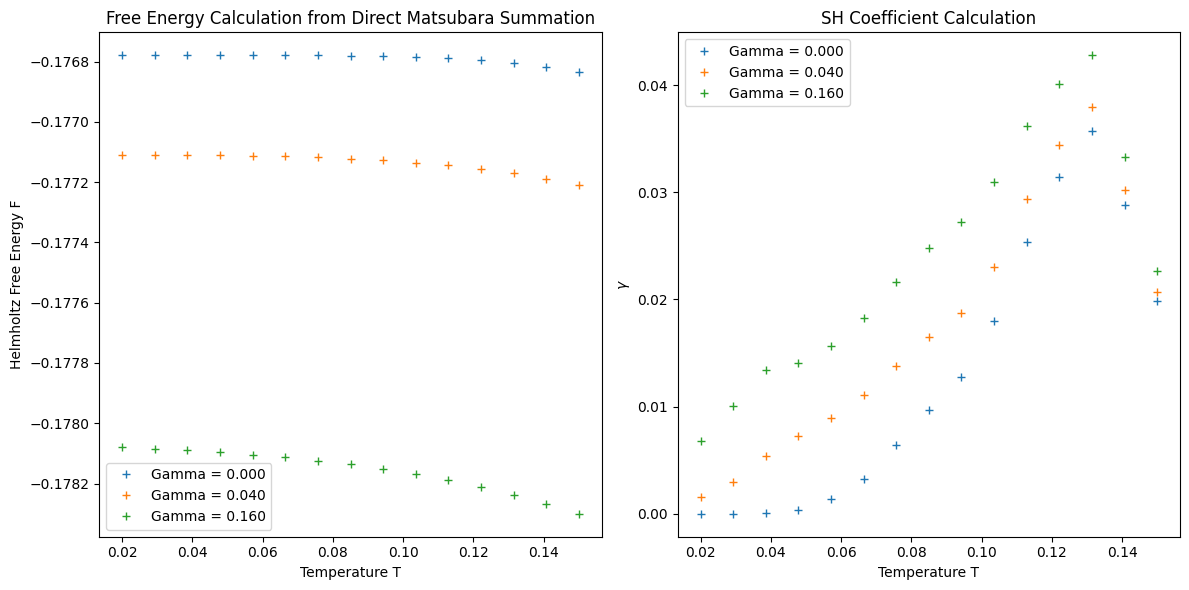

In [9]:
"""
plt.plot(T_arr, Delta_h_arr[2,:],'+',label = 'hole')
plt.plot(T_arr, Delta_e_arr[2,:], '+',label = 'electron')
# plt.xlim(0,0.02)
plt.legend(loc = 'best')
plt.title('SC Order Parameter with Impurities at low T')
plt.show()
"""

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot F_arr against T on the first subplot
for i in range(np.size(Gamma_arr)):
    axes[0].plot(T_arr, F_arr[i, :], '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[0].set_xlabel('Temperature T')
# axes[0].set_xlim(0,0.02)
axes[0].set_ylabel('Helmholtz Free Energy F')
axes[0].legend(loc='best')
axes[0].set_title('Free Energy Calculation from Direct Matsubara Summation')

# Plot C_arr (heat capacity) against T on the second subplot
for i in range(np.size(Gamma_arr)):
    axes[1].plot(T_arr, C_arr[i, :] / T_arr, '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[1].set_xlabel('Temperature T')
axes[1].set_ylabel('$\gamma$')
axes[1].legend(loc='best')
axes[1].set_title('SH Coefficient Calculation')
# axes[1].set_ylim(0,0.1)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Discussion
The previous kink in OP gets smaller at low T, hence indicating it IS a problem with Matsubara summation. Hence, at low T we have increased the number of Matsubara points used to enforce convergence such that the maximum Matsubara frequency is a constant for T < 0.10K. At T >= 0.10 K, we evaluate over 10,000 points.

## Earlier attempts
In chronological order. Go to the old folder for more generated data and attempts.

In [ ]:
# calculate gamma_n(T)
T_arr = np.linspace(Tmin,1,100)
Gamma = 0.01
N_FPade = 100

FPade_dict = np.load('FPade_Poles_and_Weights.npy',allow_pickle=True).item()
poles, weights = find_best_Pade_params(N_FPade, FPade_dict)

F_arr_normal = np.zeros(len(T_arr))
for i in range(len(T_arr)):
    T = T_arr[i]
    omega_arr = np.real(poles * T)

    _, _, Tildes_total = ChiMatsu_FPade(T, 0,0 , Gamma, poles, weights)
    F_arr_normal[i] = free_energy_perturbation_FPade(T, 0, 0, Tildes_total)
    


In [ ]:
# load data
loc = r'Gaps_Long_0911\gaps_short_zoomed_in.txt'
gamma_values, t_over_tc_values, delta_h_values, delta_e_values, tildes_total_3d, mask_list = load_gap_results(loc)



In [ ]:
gamma_index_list = [0,2, 4, 6, 7]
gamma_list = []
F_arr_list = []
Tc_list = []
t_over_tc_list = []
for i in range(len(gamma_index_list)):
    gamma_index = gamma_index_list[i]
    mask = mask_list[gamma_index]
    gamma = gamma_values[mask][gamma_index]
    t_over_tc = t_over_tc_values[mask]
    Delta_e = delta_h_values[mask] # so that Delta_h is strictly positive (this was swapped in this calculation)
    Delta_h = delta_e_values[mask]
    tildes_total = [tildes for tildes, include in zip(tildes_total_3d, mask) if include]

    Tc_imp_arr = np.loadtxt('Tc.txt')
    tc = closest_values(Tc_imp_arr[0], Tc_imp_arr[1],gamma)[0]
    
    F_arr = np.zeros(len(t_over_tc))
    for j in range(len(t_over_tc)):
        F_arr[j] = free_energy_perturbation_FPade(t_over_tc[j]*tc,Delta_h[j],Delta_e[j],tildes_total[j])
    gamma_list.append(gamma)
    t_over_tc_list.append(t_over_tc)
    F_arr_list.append(F_arr)
    Tc_list.append(tc)



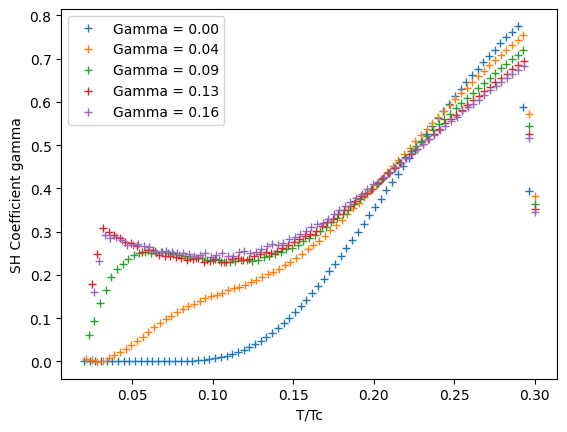

In [ ]:
for i in range(len(gamma_index_list)):
    t_over_tc = t_over_tc_list[i]
    tc = Tc_list[i]
    F_arr = F_arr_list[i]
    gamma =  gamma_list[i]
    plt.plot(t_over_tc, heat_capacity_F(F_arr,t_over_tc * tc) / (t_over_tc * tc) / (0.012 * 4.4) ,'+', label = f'Gamma = {gamma:.2f}')
# plt.plot(T_arr / tc, 4.4*entropy_F(F_arr_normal, T_arr), '-')
plt.xlabel('T/Tc')
plt.ylabel('SH Coefficient gamma')
plt.legend(loc= 'best')
plt.show()

In [ ]:
# load data directly
# Define the directory where your .npy files are stored
directory = 'data'

# calculate free energy at different temperature and impurity level
Gamma_arr = np.array([0,0.01,0.04,0.08])
T_arr = np.linspace(Tmin, 0.45, 64)
F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
C_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_h_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_e_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        G_arr, Tildes_total = load_results(T_eval, Gamma, directory)
        _, Delta_h, Delta_e = unnormalised_Delta_from_tildes(Tildes_total[0], Gamma)
        Delta_h_arr[i,j] = Delta_h
        Delta_e_arr[i,j] = Delta_e
        F_arr[i,j] = free_energy_perturbation(T_eval,Gamma,Tildes_total)
        # F_arr[i,j] = free_energy(G_arr,Delta_h,Delta_e, T_eval)
for i in range(np.size(Gamma_arr)):
    Gamma = Gamma_arr[i]
    C_arr[i,:] = heat_capacity_F(F_arr[i,:], T_arr)

T0.002_Gamma0.000_G_arr.npy
T0.009_Gamma0.000_G_arr.npy


C:\Users\tcsxx\AppData\Local\Temp\ipykernel_24180\3018282064.py:2: RuntimeWarning: overflow encountered in cosh
  return np.where(x < 30, np.log(np.cosh(x)), x - np.log(2))


T0.016_Gamma0.000_G_arr.npy
T0.023_Gamma0.000_G_arr.npy
T0.030_Gamma0.000_G_arr.npy
T0.038_Gamma0.000_G_arr.npy
T0.045_Gamma0.000_G_arr.npy
T0.052_Gamma0.000_G_arr.npy
T0.059_Gamma0.000_G_arr.npy
T0.066_Gamma0.000_G_arr.npy
T0.073_Gamma0.000_G_arr.npy
T0.080_Gamma0.000_G_arr.npy
T0.087_Gamma0.000_G_arr.npy
T0.094_Gamma0.000_G_arr.npy
T0.102_Gamma0.000_G_arr.npy
T0.109_Gamma0.000_G_arr.npy
T0.116_Gamma0.000_G_arr.npy
T0.123_Gamma0.000_G_arr.npy
T0.130_Gamma0.000_G_arr.npy
T0.137_Gamma0.000_G_arr.npy
T0.144_Gamma0.000_G_arr.npy
T0.151_Gamma0.000_G_arr.npy
T0.158_Gamma0.000_G_arr.npy
T0.166_Gamma0.000_G_arr.npy
T0.173_Gamma0.000_G_arr.npy
T0.180_Gamma0.000_G_arr.npy
T0.187_Gamma0.000_G_arr.npy
T0.194_Gamma0.000_G_arr.npy
T0.201_Gamma0.000_G_arr.npy
T0.208_Gamma0.000_G_arr.npy
T0.215_Gamma0.000_G_arr.npy
T0.222_Gamma0.000_G_arr.npy
T0.230_Gamma0.000_G_arr.npy
T0.237_Gamma0.000_G_arr.npy
T0.244_Gamma0.000_G_arr.npy
T0.251_Gamma0.000_G_arr.npy
T0.258_Gamma0.000_G_arr.npy
T0.265_Gamma0.000_G_

T0.002_Gamma0.040_G_arr.npy


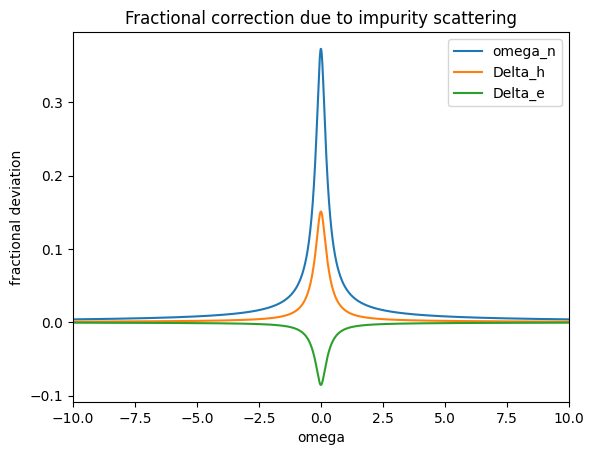

In [76]:
# plot the correction from impurity scattering explicitely and determine if a perturbative expansion can be carried out
i = 2
j = 0
Gamma = Gamma_arr[i]
T_eval = T_arr[j]
G_arr, Tildes_total = load_results(T_eval, Gamma, directory)
_, Delta_h, Delta_e = unnormalised_Delta_from_tildes(Tildes_total[0], Gamma)

# calculate the self-energy correction
maxN = np.size(Tildes_total[:,0])/2
omega_arr = omegaMatsu(np.arange(-maxN, maxN),T_eval)
delta_omega = Tildes_total[:,0] - omega_arr
delta_Delta_h = Tildes_total[:,1] - Delta_h 
delta_Delta_e = Tildes_total[:,2] - Delta_e 

plt.plot(omega_arr, delta_omega / omega_arr,label = 'omega_n')
plt.plot(omega_arr, delta_Delta_h / Delta_h, label = 'Delta_h')
plt.plot(omega_arr, delta_Delta_e / Delta_e, label = 'Delta_e')
plt.xlabel('omega')
plt.ylabel('fractional deviation')
# plt.plot(omega_arr,1/omega_arr)
plt.xlim(-10,10)
plt.title('Fractional correction due to impurity scattering')
plt.legend(loc = 'best')
plt.show()

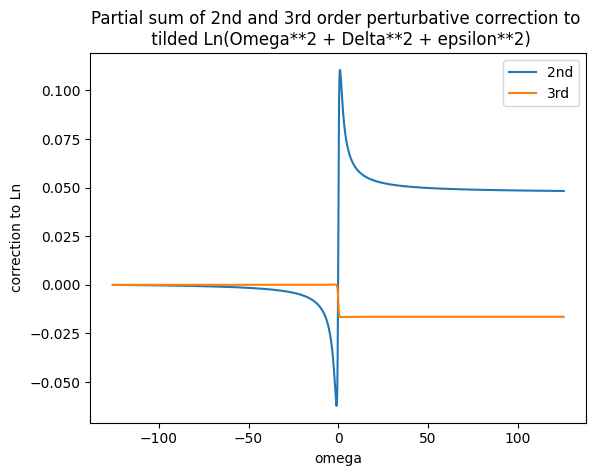

In [78]:
# plt.plot(omega_arr, partialSum(first_order_correction(omega_arr, Delta_h, 1, delta_omega, delta_Delta_h)),label = 'omega_n')
plt.plot(omega_arr, partialSum(second_order_correction(omega_arr, Delta_h, 1, delta_omega, delta_Delta_h)),label = '2nd')
plt.plot(omega_arr, partialSum(third_order_correction(omega_arr, Delta_h, 1, delta_omega, delta_Delta_h)),label = '3rd')
plt.xlabel('omega')
plt.ylabel('correction to Ln')
plt.title('Partial sum of 2nd and 3rd order perturbative correction to \n tilded Ln(Omega**2 + Delta**2 + epsilon**2)')
plt.legend(loc = 'best')
plt.show()

#### Discussion
The maximum fractional correction of impurity scattering occurs at zero Matsubara frequency at zero temperature, and is limited to 30%. At $T > 0.15K,$ the maximum fractional correction becomes smaller than $10\%.$ The high-$\omega_n$ correction goes as $1/\omega_n$ as confirmed by a log-log plot. Hence, the correction truncates in a $\mathcal{O}(\omega_n^{-2})$ manner. Also, at low $T$ and low $\omega,$ $\Delta \gg \omega_n$ on the denomenator which should suppress the error coming from perturbation 

The way forward
1. Carry out a perturbative expansion to second order naively and see how things go. 
2. Explicitely sum over the $\omega_n$ up to a small value (say 10?) without renormalisation. Perform the perturbation with renormalised F0 for larger $\omega_n$ But since the renormalised sum and the original series are qualitatively different, this may not work very well.

<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_24180\261984177.py:14: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_ylabel('$\gamma$')


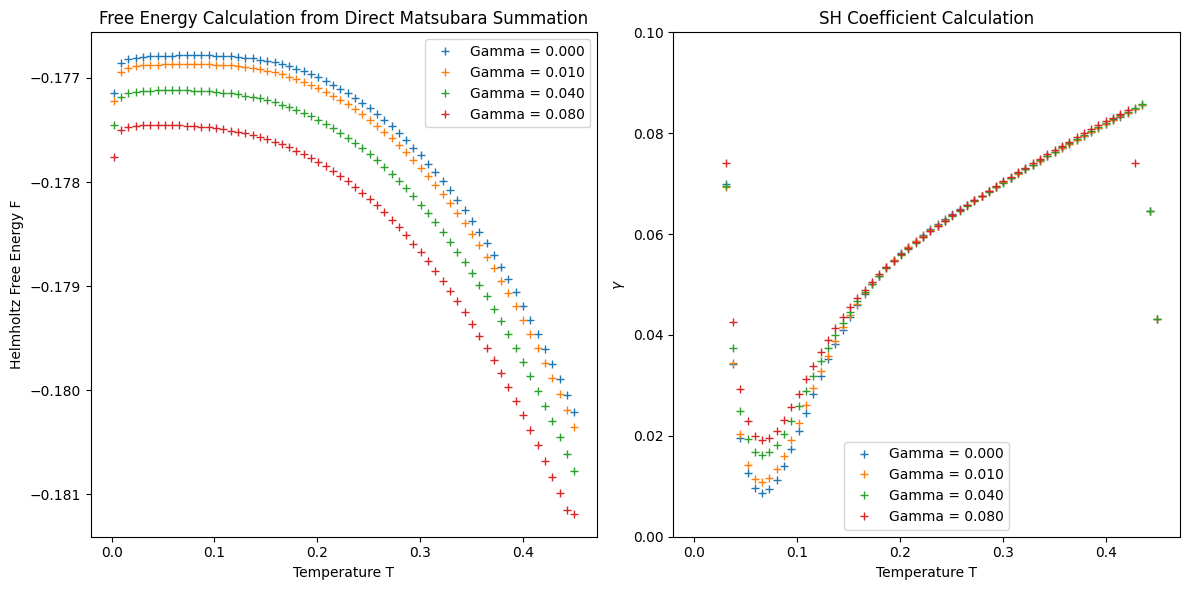

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot F_arr against T on the first subplot
for i in range(np.size(Gamma_arr)):
    axes[0].plot(T_arr, F_arr[i, :], '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[0].set_xlabel('Temperature T')
axes[0].set_ylabel('Helmholtz Free Energy F')
axes[0].legend(loc='best')
axes[0].set_title('Free Energy Calculation from Direct Matsubara Summation')

# Plot C_arr (heat capacity) against T on the second subplot
for i in range(np.size(Gamma_arr)):
    axes[1].plot(T_arr, C_arr[i, :] / T_arr, '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[1].set_xlabel('Temperature T')
axes[1].set_ylabel('$\gamma$')
axes[1].legend(loc='best')
axes[1].set_title('SH Coefficient Calculation')
axes[1].set_ylim(0,0.1)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Discussion
Apart from the divergence for $T < 0.05K,$ we recovered a similar behaviour in $\gamma$ to the clean limit. It also agrees wih the Bang2017 paper in that impurity effects are only significant at low temperature. The divergence at low $T$ is due to a kink in the order parameters for $T < 0.05K$ with unknown origin. The kink is not present when calculating a clean superconductor, but is present for Gamma = 0 in the Bang2017 formalism, hence it is likely due to some ill considerations in the numerical procedure. I suspect perhaps the limits of Matsubara frequencies and energy integral not large enough? 


#### Low-temperature zoom in
Below we zoomed into the $T < 0.1K$ region and see what's going on. 

In [ ]:
# calculate free energy at different temperature and impurity level. Takes ~3 hours
Gamma_arr = np.array([0,0.04,0.08])
T_arr = np.linspace(0.001, 0.1, 128)
F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        F_arr[i,j] = free_energy_wrapper(T_eval,Gamma, subfolder_name='data2_new_lowT')


Solving the gap equations at T = 0.001 and Gamma = 0.0 takes 65.73133 seconds


C:\Users\tcsxx\AppData\Local\Temp\ipykernel_9972\2830979573.py:3: RuntimeWarning: overflow encountered in cosh
  return np.where(x < 30, np.log(np.cosh(x)), x - np.log(2))


Solving the gap equations at T = 0.001779527559055118 and Gamma = 0.0 takes 59.16702 seconds
Solving the gap equations at T = 0.002559055118110236 and Gamma = 0.0 takes 60.63367 seconds
Solving the gap equations at T = 0.0033385826771653547 and Gamma = 0.0 takes 60.41813 seconds
Solving the gap equations at T = 0.004118110236220473 and Gamma = 0.0 takes 55.59462 seconds
Solving the gap equations at T = 0.004897637795275591 and Gamma = 0.0 takes 54.68623 seconds
Solving the gap equations at T = 0.005677165354330709 and Gamma = 0.0 takes 54.24604 seconds
Solving the gap equations at T = 0.006456692913385827 and Gamma = 0.0 takes 55.32917 seconds
Solving the gap equations at T = 0.0072362204724409455 and Gamma = 0.0 takes 54.41655 seconds
Solving the gap equations at T = 0.008015748031496064 and Gamma = 0.0 takes 56.14941 seconds
Solving the gap equations at T = 0.008795275590551183 and Gamma = 0.0 takes 53.33298 seconds
Solving the gap equations at T = 0.0095748031496063 and Gamma = 0.0 

In [198]:
# Define the directory where your .npy files are stored
directory = 'data2_new_lowT'

# calculate free energy at different temperature and impurity level
Gamma_arr = np.array([0,0.04,0.08])
T_arr = np.linspace(0.001, 0.1, 128)

F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
C_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_h_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
Delta_e_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        G_arr, Tildes_total = load_results(T_eval, Gamma, directory)
        _, Delta_h, Delta_e = unnormalised_Delta_from_tildes(Tildes_total[0], Gamma)
        Delta_h_arr[i,j] = Delta_h
        Delta_e_arr[i,j] = Delta_e
        F_arr[i,j] = free_energy_perturbation(T_eval,Gamma,Tildes_total)
        # F_arr[i,j] = free_energy(G_arr,Delta_h,Delta_e, T_eval)
for i in range(np.size(Gamma_arr)):
    Gamma = Gamma_arr[i]
    C_arr[i,:] = heat_capacity_F(F_arr[i,:], T_arr)

C:\Users\tcsxx\AppData\Local\Temp\ipykernel_24440\3292851208.py:3: RuntimeWarning: overflow encountered in cosh
  return np.where(x < 30, np.log(np.cosh(x)), x - np.log(2))


KeyboardInterrupt: 

<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_21172\1391520404.py:22: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_ylabel('$\gamma$')


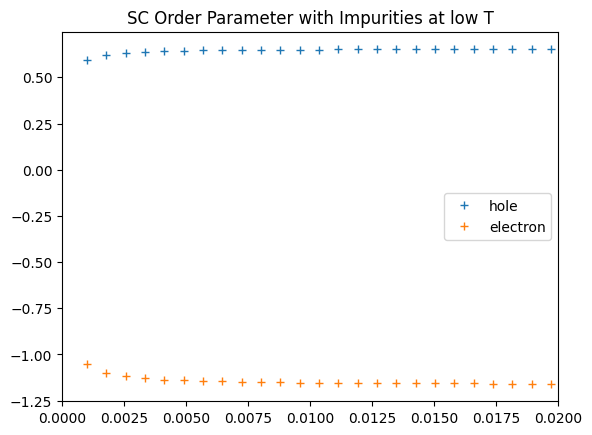

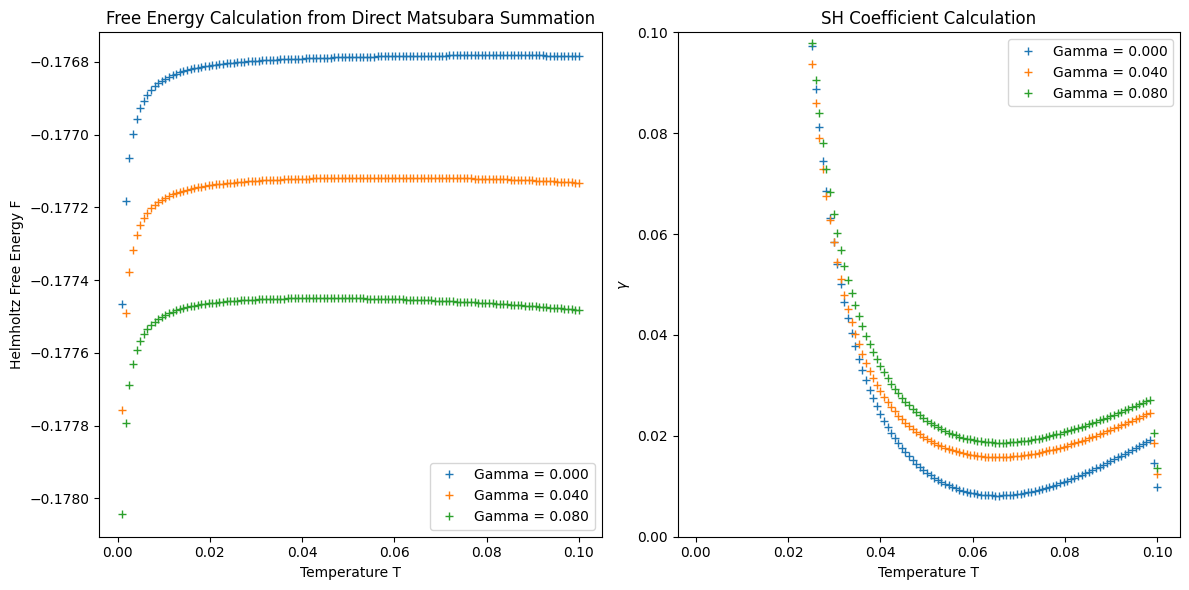

In [27]:
plt.plot(T_arr, Delta_h_arr[0,:],'+',label = 'hole')
plt.plot(T_arr, Delta_e_arr[0,:], '+',label = 'electron')
plt.xlim(0,0.02)
plt.legend(loc = 'best')
plt.title('SC Order Parameter with Impurities at low T')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot F_arr against T on the first subplot
for i in range(np.size(Gamma_arr)):
    axes[0].plot(T_arr, F_arr[i, :], '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[0].set_xlabel('Temperature T')
# axes[0].set_xlim(0,0.02)
axes[0].set_ylabel('Helmholtz Free Energy F')
axes[0].legend(loc='best')
axes[0].set_title('Free Energy Calculation from Direct Matsubara Summation')

# Plot C_arr (heat capacity) against T on the second subplot
for i in range(np.size(Gamma_arr)):
    axes[1].plot(T_arr, C_arr[i, :] / T_arr, '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[1].set_xlabel('Temperature T')
axes[1].set_ylabel('$\gamma$')
axes[1].legend(loc='best')
axes[1].set_title('SH Coefficient Calculation')
axes[1].set_ylim(0,0.1)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Discussion
OP increases until T ~ 0.08K. maybe because of small truncation for matsubara sum? try a larger one at low temperature

#### Include 10^6 terms in the Matsubara sum, and examine the kink

## VII. Pade Approximation and Analytic Continuation
this is merely a sanity check that things made sense. It's not the path I took to calculate heat capacities.

In [ ]:

# repeat the process of finding the Green's function
# self-consistently solve for the tildes after guessing the untilded parameters
T_eval = 1e-2
Delta_h_init, Delta_e_init = initD # clean gap size

# Find the order parameters from the gap equations.
ifSolveGap = False
if ifSolveGap:
    startT = time.time()
    res = SolveGap(initD,T_eval,0.04)
    endT = time.time()
    print(f'Solving the gap equations takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    np.savetxt('Tildes_total.txt',Tildes_total)
else:
    Tildes_total = np.loadtxt('Tildes_total.txt')
    Delta_out = np.array(unnormalised_Delta_from_tildes(Tildes_total[0],0.04))[1:]

Omega_Tilde = np.array([Tildes_total[i][0] for i in range(len(Tildes_total))])
Delta_h_Tilde = np.array([Tildes_total[i][1] for i in range(len(Tildes_total))])
Delta_e_Tilde = np.array([Tildes_total[i][2] for i in range(len(Tildes_total))])

# evaluate Green's function at Matsubara frequencies
omega = np.zeros(2*max_it(T_eval))
for n in np.arange(-max_it(T_eval),max_it(T_eval)):
    omega[n+ max_it(T_eval)] = omegaMatsu(n,T_eval)
G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),0.04)

In [ ]:
# testing the Pade approximation
def f(z):
    return np.tanh(z)
z_arr = np.linspace(-5,5,100)
f_arr = f(z_arr)

z_fine = np.linspace(-5,5,100)*1j
f_eval = pade(z_fine,z_arr,f_arr)

plt.plot(z_arr, np.tan(z_arr), '+')
plt.plot(np.imag(z_fine), np.imag(f_eval), '--')
plt.show()

In [ ]:
a_test = padecoeffs(omega, G_arr[:,0,0])

In [ ]:
G_h_imag = padeeval(w_imag,omega,a_test) # analytic continuation to the imaginary axis
G_e_imag = 0

DoS = -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)

omega_real_fine = np.linspace(-100,100,5000) # plot on the real axis to test Pade approximation
G_h_real = padeeval(omega, omega, a_test)

In [ ]:
# Assuming G_arr and omega are already defined
N_sample = 100 # too high -> amplitude of oscillation at large frequency at large, too low -> bad convergence hence get spikes N = 150 seems like a good balance
omega_matsu_cutoff = 15 * Omega_c
central_omega = 0.4 * Omega_c

# Split omega and G_arr into regions
central_region_mask = np.abs(omega) <= central_omega
outer_region_mask = (np.abs(omega) > central_omega) & (np.abs(omega) < omega_matsu_cutoff)

# Extract the indices for central and outer regions
central_indices = np.where(central_region_mask)[0]
outer_indices = np.where(outer_region_mask)[0]

# Perform uniform random sampling without replacement for each region
central_sample_indices = random.sample(list(central_indices), N_sample // 2)
outer_sample_indices = random.sample(list(outer_indices), N_sample // 2)

# Combine samples and indices
indices_sample = np.concatenate((central_sample_indices, outer_sample_indices))
G_arr_sample = G_arr[indices_sample, 0, 0]

# Extract the corresponding omega samples
omega_sample = omega[indices_sample]

# Plot the sampled data
plt.plot(omega_sample, G_arr_sample, '+')

# Generate a finer omega sample for fitting
omega_sample_finer = np.linspace(-15*Omega_c, 15*Omega_c, 2000)
G_fit_sampled = pade(omega_sample_finer, omega_sample, G_arr_sample)
plt.plot(omega_sample_finer, G_fit_sampled, '--')
plt.ylim(-2,2)

plt.xlabel('omega')
plt.ylabel('G_h_0 on real')
plt.show()

# Generate a finer omega sample for fitting
delta = -0.5
omega_sample_finer = np.linspace(-Omega_c, Omega_c, 2000)*1j + 10**(delta)
G_fit_sampled = pade(omega_sample_finer, omega_sample, G_arr_sample)
plt.plot(np.imag(omega_sample_finer), np.real(G_fit_sampled), label = 'Re(G)')
plt.plot(np.imag(omega_sample_finer), np.imag(G_fit_sampled), label = 'Im(G)')
plt.xlabel('Im(omega)')
plt.ylabel('Analytically continued G_h_0 on imaginary axis')
plt.legend(loc = 'best')
plt.show()

In [ ]:
plt.plot(np.imag(w_imag),np.abs(G_h_imag),'+') # delta = 10^-1.1
plt.xlabel('$\omega$')
plt.ylabel('Hole density of states')
plt.show()